<a href="https://www.kaggle.com/code/bugbreaker18/vehicle-plate-detection-ocr?scriptVersionId=149580530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Project Preparation
The dataset is obtained from Satria Data Competition 2023 where they provide image data of the vehicle plates. From another notebook, I processed the vehicle plates' images into just the characters of those plates by using an external software called [labelImg](https://github.com/heartexlabs/labelImg). With this software, I was able to create training data on every characters bounding boxes in the vehicle plates. 

The following are the datasets processed:
- [plate-detection-utils](https://www.kaggle.com/datasets/vincentsuhardi/plate-detection-utils)
- [test-images](https://www.kaggle.com/datasets/vincentsuhardi/test-images)

## Importing Dependencies

In [1]:
!pip install ultralytics -qq
!pip install -U tensorflow-addons -qq

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2, glob, os, random
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO
from skimage.io import imshow
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

# ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Image & Bounding Box Visualization

## Defining Helper Functions

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [4]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [5]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.png'))
    all_images.extend(glob.glob(image_paths+'/*.PNG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.strip().split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

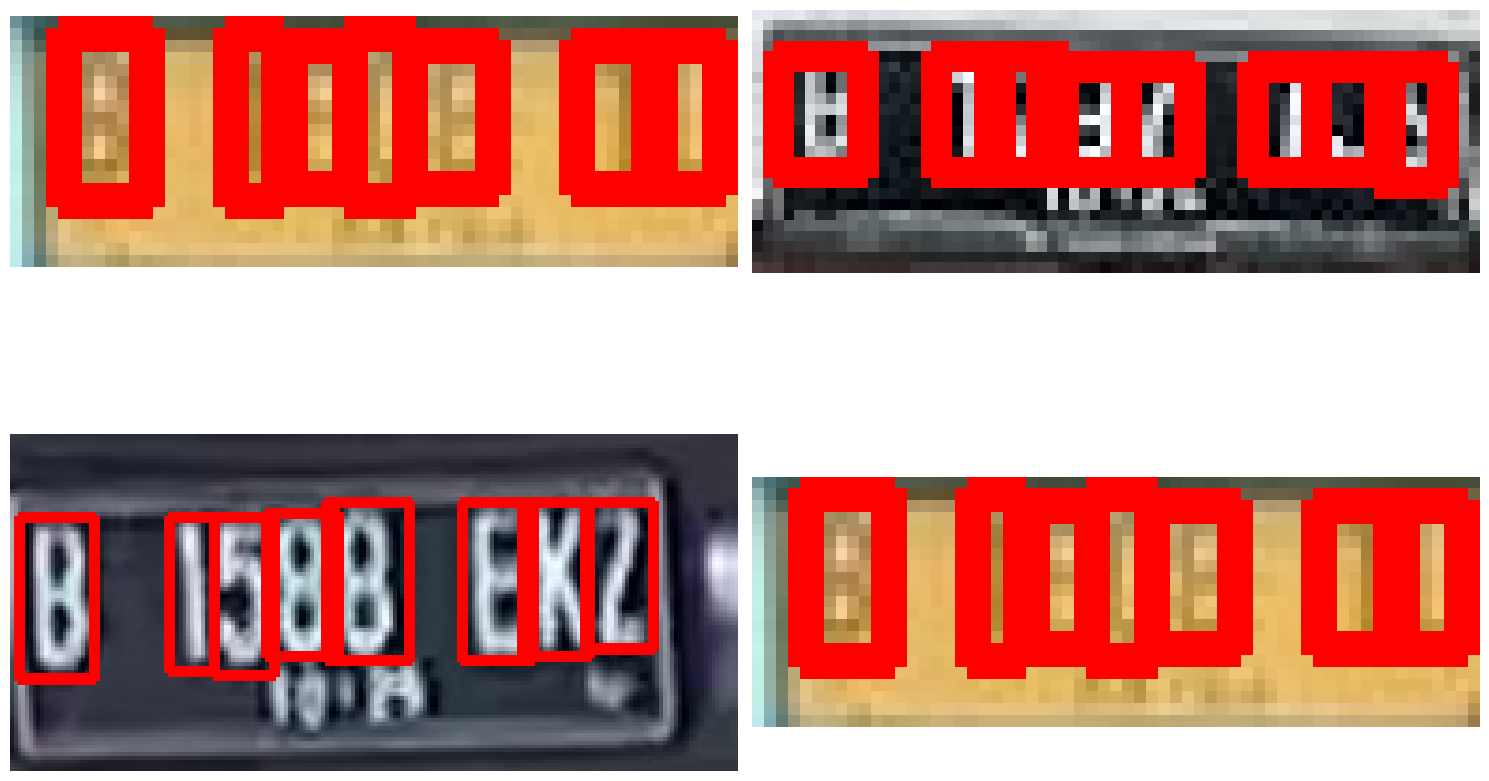

In [6]:
plot(image_paths='/kaggle/input/plate-detection-utils/data/train/images',
     label_paths='/kaggle/input/plate-detection-utils/data/train/labels',
     num_samples=4)

# YOLOv8 Modeling
For this project's object detection modeling phase, I'll be using the YOLOv8 Nano from the [Ultralytics GitHub page](https://github.com/ultralytics/ultralytics). This model learns from the locations of the bounding boxes of every `.png` image, where these locations are provided in `x,y,w,h` format in the images' corresponding text files. The model serves as a character detection model from every plate image.

## Writing `.yaml` File
This file is used to specify the locations of the training and validation directories each consisting of the image and also their corresponding labels in `.txt` format. Other than that, this file will also state the number of classes that the datasets have.

In [7]:
%%writefile data.yaml
path: '/kaggle/input/plate-detection-utils/data'
train: 'train/images'
val: 'valid/images'

nc: 16
names: ['dog', 'person', 'cat', 'tv', 'car', 'meatballs', 'marinara sauce', 'tomato soup', 'chicken noodle soup', 'french onion soup', 'chicken breast', 'ribs', 'pulled pork', 'hamburger', 'cavity', 'char']
# will only be using char class

Writing data.yaml


## Model Training

In [8]:
# EPOCH = 50
# IMG_SIZE = 320

# model = YOLO('yolov8n.pt')
# model.train(data='data.yaml', epochs=EPOCH, imgsz=IMG_SIZE, name='yolov8n_v8_50e')

## Model Validation

In [9]:
model = YOLO('/kaggle/input/plate-detection-utils/data/best.pt')
metrics = model.val()
metrics.box.map

Ultralytics YOLOv8.0.207 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 168 layers, 3008768 parameters, 0 gradients, 8.1 GFLOPs
100%|██████████| 755k/755k [00:00<00:00, 14.0MB/s]
val: Scanning /kaggle/input/plate-detection-utils/data/valid/labels... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<00:00, 125.08it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/plate-detection-utils/data/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]
                   all         23        177      0.994      0.994      0.994       0.69
                  char         23        177      0.994      0.994      0.994       0.69
Speed: 0.9ms preprocess, 11.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/val


0.6899236781609426

## Model Prediction

In [10]:
source = '/kaggle/input/test-images/test'
model.predict(source, imgsz=320, conf=0.5, name='yolov8n_v8_50e_testpred', save_txt=True, save_crop=True)


image 1/100 /kaggle/input/test-images/test/DataTest1.png: 128x320 8 chars, 62.9ms
image 2/100 /kaggle/input/test-images/test/DataTest10.png: 128x320 8 chars, 6.0ms
image 3/100 /kaggle/input/test-images/test/DataTest100.png: 96x320 7 chars, 56.1ms
image 4/100 /kaggle/input/test-images/test/DataTest11.png: 128x320 8 chars, 6.3ms
image 5/100 /kaggle/input/test-images/test/DataTest12.png: 128x320 8 chars, 6.0ms
image 6/100 /kaggle/input/test-images/test/DataTest13.png: 128x320 8 chars, 5.9ms
image 7/100 /kaggle/input/test-images/test/DataTest14.png: 128x320 7 chars, 5.8ms
image 8/100 /kaggle/input/test-images/test/DataTest15.png: 192x320 8 chars, 61.0ms
image 9/100 /kaggle/input/test-images/test/DataTest16.png: 160x320 8 chars, 58.3ms
image 10/100 /kaggle/input/test-images/test/DataTest17.png: 128x320 7 chars, 7.0ms
image 11/100 /kaggle/input/test-images/test/DataTest18.png: 128x320 8 chars, 5.7ms
image 12/100 /kaggle/input/test-images/test/DataTest19.png: 128x320 8 chars, 5.9ms
image 13/

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'dog', 1: 'person', 2: 'cat', 3: 'tv', 4: 'car', 5: 'meatballs', 6: 'marinara sauce', 7: 'tomato soup', 8: 'chicken noodle soup', 9: 'french onion soup', 10: 'chicken breast', 11: 'ribs', 12: 'pulled pork', 13: 'hamburger', 14: 'cavity', 15: 'char'}
 orig_img: array([[[ 24,   8,   2],
         [ 22,   6,   0],
         [ 20,   4,   0],
         ...,
         [141,  80,  48],
         [141,  79,  49],
         [139,  79,  50]],
 
        [[ 33,  15,   8],
         [ 32,  14,   7],
         [ 30,  12,   5],
         ...,
         [141,  80,  48],
         [139,  79,  49],
         [139,  79,  50]],
 
        [[ 49,  30,  23],
         [ 47,  28,  21],
         [ 46,  27,  20],
         ...,
         [140,  80,  50],
         [138,  80,  51],
         [138,  79,  53]],
 
        ...,
 
        [[ 49,  36,  34],
         [ 49,  36,  34],
  

## Plot Predictions

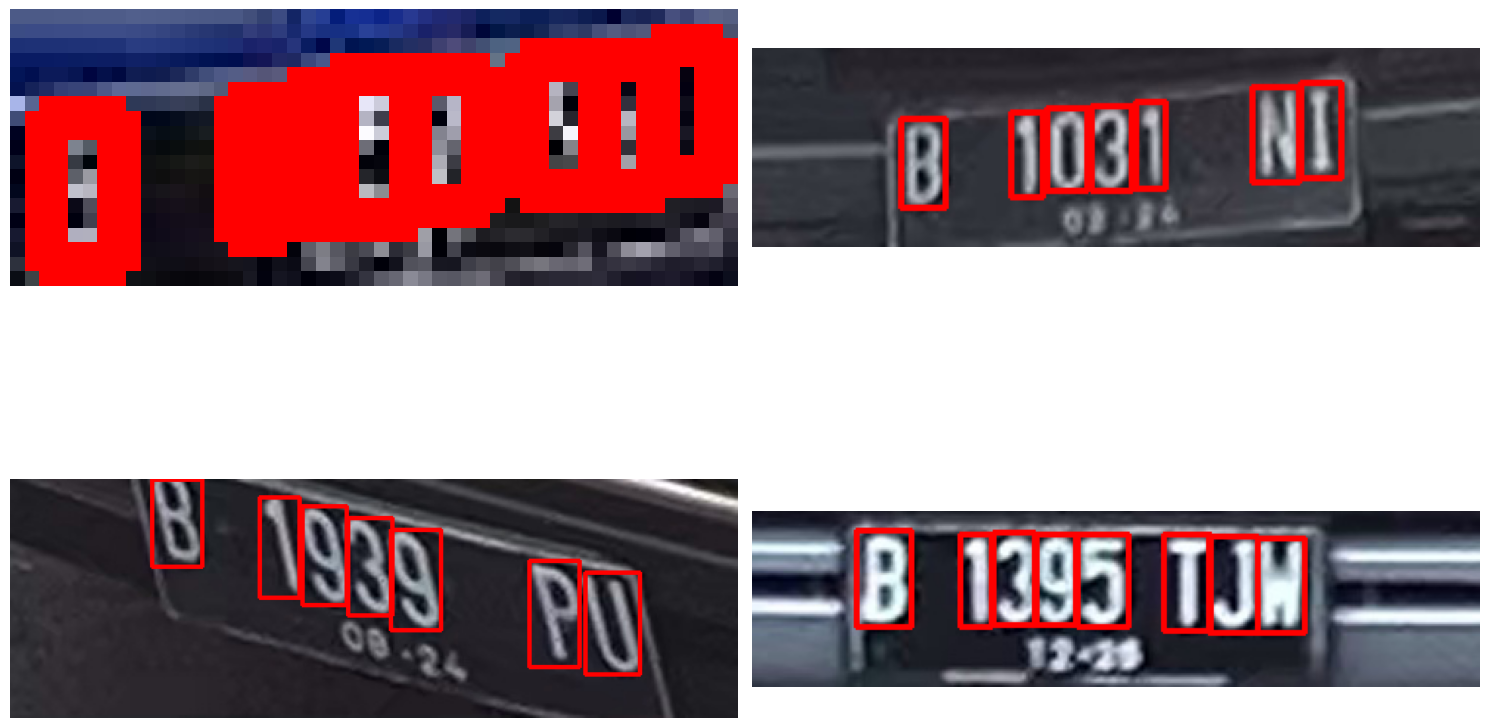

In [11]:
plot(
    image_paths='/kaggle/input/test-images/test',
    label_paths='/kaggle/working/runs/detect/yolov8n_v8_50e_testpred/labels',
    num_samples=4
)

# Character Segmentation

In [12]:
def segment(img_path, txt_path):
    image = cv2.imread(img_path)
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    bounding_box_images = []
    for line in lines:
        line = line.strip().split()
        label = line[0]
        x, y, w, h = map(float, line[1:])
        left = int((x - w / 2) * image.shape[1])
        top = int((y - h / 2) * image.shape[0])
        right = int((x + w / 2) * image.shape[1])
        bottom = int((y + h / 2) * image.shape[0])

        bbox_image = image[top:bottom, left:right]
        bounding_box_images.append((left, bbox_image))

    # Sort the bounding boxes based on their left coordinate
    bounding_box_images.sort(key=lambda x: x[0])

    # Extract the images in left-to-right order
    bounding_box_images = [bbox_image for _, bbox_image in bounding_box_images]

    return bounding_box_images


In [13]:
IMG_PATH = '/kaggle/input/test-images/test/DataTest82.png'
TXT_PATH = '/kaggle/working/runs/detect/yolov8n_v8_50e_testpred/labels/DataTest82.txt'

seg_img = segment(IMG_PATH, TXT_PATH)

In [14]:
chars = []
for char in seg_img:
  chars.append(cv2.resize(char, (24, 43)))

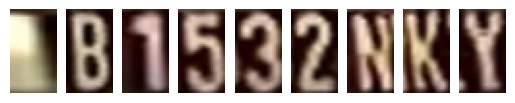

In [15]:
for i in range(len(chars)):
  plt.subplot(1, len(chars), i+1)
  plt.imshow(chars[i], cmap='gray')
  plt.axis('off')
plt.show()

# Image Formatting

In [16]:
def format_img(img_arr):
  gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
#   blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#   sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
#   _, black_white = cv2.threshold(sharpened, 127, 255, cv2.THRESH_BINARY)

  return gray

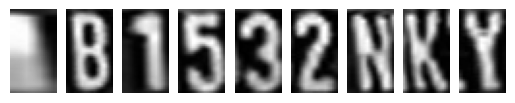

In [17]:
chars = [format_img(char) for char in chars]

for i in range(len(chars)):
  plt.subplot(1, len(chars), i+1)
  plt.imshow(chars[i], cmap='gray')
  plt.axis('off')
plt.show()

# Training Custom Model
After detecting the characters from the vehicle plates, I'll now build a custom CNN model that will learn based on the data I've obtained on characters from the training dataset to classify the segmented characters.

In [18]:
datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = '/kaggle/input/plate-detection-utils'

train_gen = datagen.flow_from_directory(
    os.path.join(path, 'train_img'),
    target_size=(32,32),
    batch_size=1,
    class_mode='categorical'
)
val_gen = datagen.flow_from_directory(
    os.path.join(path, 'val_img'),
    target_size=(32,32),
    batch_size=1,
    class_mode='categorical'
)

Found 1883 images belonging to 36 classes.
Found 488 images belonging to 36 classes.


In [19]:
# callbacks
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001, 
                              mode = 'min', verbose = 1)
model_save = ModelCheckpoint('./LicensePlateModelv2_best_weights.h5',
                            save_best_only=True,
                            save_weights_only=True,
                            monitor='val_loss',
                            mode='min',
                            verbose=0)
# early_stopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0.001,
#                               patience=8,
#                               mode='min',
#                               verbose=0,
#                               restore_best_weights=True)
tqdm = tfa.callbacks.TQDMProgressBar()

In [20]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))

model.add(Dense(36,activation ="softmax"))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [27]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [28]:
history = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // 1,
    validation_data = val_gen,
    epochs=80,
    verbose=0,
    callbacks=[tqdm, reduce_lr, model_save]
)

Training:   0%|           0/80 ETA: ?s,  ?epochs/s

Epoch 1/80


0/1883           ETA: ?s - 

Epoch 2/80


0/1883           ETA: ?s - 

Epoch 3/80


0/1883           ETA: ?s - 

Epoch 4/80


0/1883           ETA: ?s - 

Epoch 5/80


0/1883           ETA: ?s - 

Epoch 6/80


0/1883           ETA: ?s - 


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 7/80


0/1883           ETA: ?s - 

Epoch 8/80


0/1883           ETA: ?s - 

Epoch 9/80


0/1883           ETA: ?s - 


Epoch 9: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 10/80


0/1883           ETA: ?s - 

Epoch 11/80


0/1883           ETA: ?s - 

Epoch 12/80


0/1883           ETA: ?s - 

Epoch 13/80


0/1883           ETA: ?s - 


Epoch 13: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 14/80


0/1883           ETA: ?s - 

Epoch 15/80


0/1883           ETA: ?s - 

Epoch 16/80


0/1883           ETA: ?s - 

Epoch 17/80


0/1883           ETA: ?s - 


Epoch 17: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 18/80


0/1883           ETA: ?s - 

Epoch 19/80


0/1883           ETA: ?s - 


Epoch 19: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 20/80


0/1883           ETA: ?s - 

Epoch 21/80


0/1883           ETA: ?s - 


Epoch 21: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 22/80


0/1883           ETA: ?s - 

Epoch 23/80


0/1883           ETA: ?s - 


Epoch 23: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
Epoch 24/80


0/1883           ETA: ?s - 

Epoch 25/80


0/1883           ETA: ?s - 


Epoch 25: ReduceLROnPlateau reducing learning rate to 6.561000276406048e-08.
Epoch 26/80


0/1883           ETA: ?s - 

Epoch 27/80


0/1883           ETA: ?s - 


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9683000829218145e-08.
Epoch 28/80


0/1883           ETA: ?s - 

Epoch 29/80


0/1883           ETA: ?s - 


Epoch 29: ReduceLROnPlateau reducing learning rate to 5.904900035602622e-09.
Epoch 30/80


0/1883           ETA: ?s - 

Epoch 31/80


0/1883           ETA: ?s - 


Epoch 31: ReduceLROnPlateau reducing learning rate to 1.7714700373261393e-09.
Epoch 32/80


0/1883           ETA: ?s - 

Epoch 33/80


0/1883           ETA: ?s - 


Epoch 33: ReduceLROnPlateau reducing learning rate to 5.314410245205181e-10.
Epoch 34/80


0/1883           ETA: ?s - 

Epoch 35/80


0/1883           ETA: ?s - 


Epoch 35: ReduceLROnPlateau reducing learning rate to 1.5943230069481729e-10.
Epoch 36/80


0/1883           ETA: ?s - 

Epoch 37/80


0/1883           ETA: ?s - 


Epoch 37: ReduceLROnPlateau reducing learning rate to 4.7829690208445185e-11.
Epoch 38/80


0/1883           ETA: ?s - 

Epoch 39/80


0/1883           ETA: ?s - 


Epoch 39: ReduceLROnPlateau reducing learning rate to 1.434890747886719e-11.
Epoch 40/80


0/1883           ETA: ?s - 

Epoch 41/80


0/1883           ETA: ?s - 


Epoch 41: ReduceLROnPlateau reducing learning rate to 4.304672243660157e-12.
Epoch 42/80


0/1883           ETA: ?s - 

Epoch 43/80


0/1883           ETA: ?s - 


Epoch 43: ReduceLROnPlateau reducing learning rate to 1.2914016210563428e-12.
Epoch 44/80


0/1883           ETA: ?s - 

Epoch 45/80


0/1883           ETA: ?s - 


Epoch 45: ReduceLROnPlateau reducing learning rate to 3.874204993273289e-13.
Epoch 46/80


0/1883           ETA: ?s - 

Epoch 47/80


0/1883           ETA: ?s - 


Epoch 47: ReduceLROnPlateau reducing learning rate to 1.162261530508052e-13.
Epoch 48/80


0/1883           ETA: ?s - 

Epoch 49/80


0/1883           ETA: ?s - 


Epoch 49: ReduceLROnPlateau reducing learning rate to 3.4867844288938296e-14.
Epoch 50/80


0/1883           ETA: ?s - 

Epoch 51/80


0/1883           ETA: ?s - 


Epoch 51: ReduceLROnPlateau reducing learning rate to 1.0460353083393582e-14.
Epoch 52/80


0/1883           ETA: ?s - 

Epoch 53/80


0/1883           ETA: ?s - 


Epoch 53: ReduceLROnPlateau reducing learning rate to 3.138105874196098e-15.
Epoch 54/80


0/1883           ETA: ?s - 

Epoch 55/80


0/1883           ETA: ?s - 


Epoch 55: ReduceLROnPlateau reducing learning rate to 9.414317622588293e-16.
Epoch 56/80


0/1883           ETA: ?s - 

Epoch 69/80


0/1883           ETA: ?s - 


Epoch 69: ReduceLROnPlateau reducing learning rate to 2.0589113778655536e-19.
Epoch 70/80


0/1883           ETA: ?s - 

Epoch 71/80


0/1883           ETA: ?s - 


Epoch 71: ReduceLROnPlateau reducing learning rate to 6.176734056048479e-20.
Epoch 72/80


0/1883           ETA: ?s - 

Epoch 73/80


0/1883           ETA: ?s - 


Epoch 73: ReduceLROnPlateau reducing learning rate to 1.8530202168145436e-20.
Epoch 74/80


0/1883           ETA: ?s - 

Epoch 75/80


0/1883           ETA: ?s - 


Epoch 75: ReduceLROnPlateau reducing learning rate to 5.559060844314087e-21.
Epoch 76/80


0/1883           ETA: ?s - 

Epoch 77/80


0/1883           ETA: ?s - 


Epoch 77: ReduceLROnPlateau reducing learning rate to 1.667718253294226e-21.
Epoch 78/80


0/1883           ETA: ?s - 

Epoch 79/80


0/1883           ETA: ?s - 


Epoch 79: ReduceLROnPlateau reducing learning rate to 5.003154881051713e-22.
Epoch 80/80


0/1883           ETA: ?s - 

Minimum validation loss: 0.4321869909763336
Maximum accuracy: 0.9036885499954224


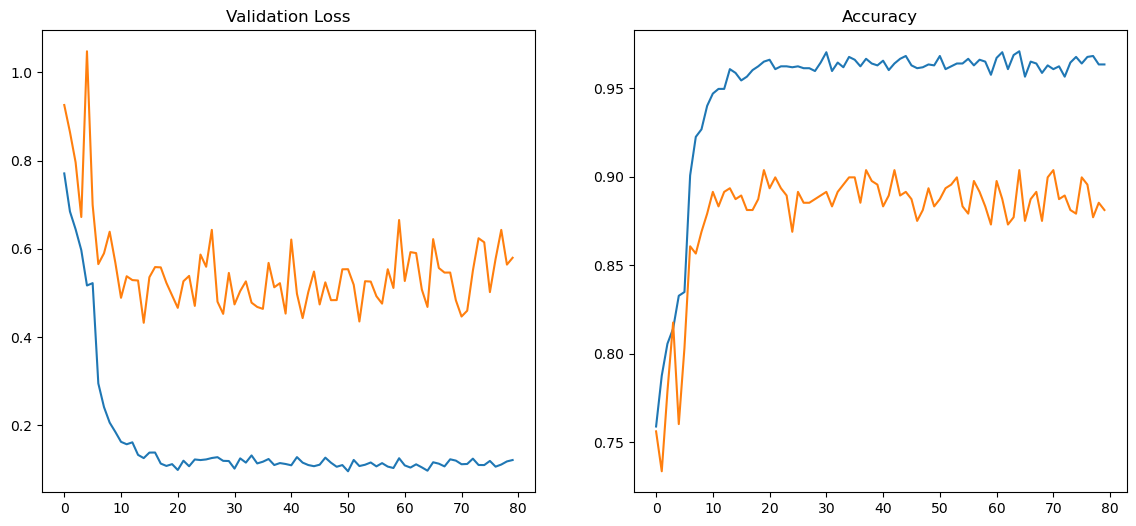

In [29]:
import pandas as pd

fig, axs = plt.subplots(1, 2, figsize=(14,6))
history_df = pd.DataFrame(history.history)

axs[0].set_title('Validation Loss')
axs[0].plot(history_df.loc[:, ['loss', 'val_loss']])
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

axs[1].set_title('Accuracy')
axs[1].plot(history_df.loc[:, ['acc', 'val_acc']])
print("Maximum accuracy: {}".format(history_df['val_acc'].max()))

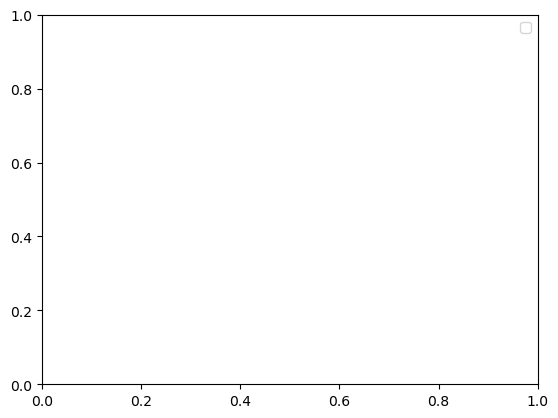

In [30]:
plt.legend()
plt.show()

# Predictions with Custom Model

In [34]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())

    model.add(Dense(64,activation ="relu"))
    model.add(Dense(128,activation ="relu"))

    model.add(Dense(36,activation ="softmax"))
    return model

from keras.models import load_model
model_loaded = create_model()
model_loaded.load_weights('LicensePlateModelv2_best_weights.h5')

In [35]:
def fix_dimension(img):
  new_img = np.zeros((32,32,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img

def show_results():
  dic = {}
  characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  for i, c in enumerate(characters):
    dic[i] = c

  output = []
  for i, ch in enumerate(chars):
    img = cv2.resize(ch, (32,32), interpolation=cv2.INTER_AREA)
    img = fix_dimension(img)
    img = img.reshape(1,32,32,3)
    y = model_loaded.predict(img)
    pred_class = np.argmax(y, axis=-1)[0]
    output.append(dic[pred_class])
    
  plate_number = ''.join(output)
  return plate_number
        

print(show_results())

1/1 [==============================] - 0s 21ms/step
AB1532NKY


# Final Data Formatting

In [36]:
image_files = glob.glob('/kaggle/input/test-images/test/*.png')    
label_files = glob.glob('/kaggle/working/runs/detect/yolov8n_v8_50e_testpred/labels/*.txt')

image_names = [os.path.splitext(os.path.basename(file))[0] for file in image_files]
label_names = [os.path.splitext(os.path.basename(file))[0] for file in label_files]

# sort lists
image_names = sorted(image_names, key=lambda x: int(x[8:]))
label_names = sorted(label_names, key=lambda x: int(x[8:]))

image_path = '/kaggle/input/test-images/test'
label_path = '/kaggle/working/runs/detect/yolov8n_v8_50e_testpred/labels'
seg_img = 0
results = []
for image_name in image_names:
    for label_name in label_names:
        if image_name == label_name:
            print(f"File: {image_name}")
            seg_img = segment(os.path.join(image_path, image_name + '.png'), os.path.join(label_path, label_name + '.txt'))
            chars = []
            for char in seg_img:
              chars.append(cv2.resize(char, (24, 43)))
            chars = [format_img(char) for char in chars]
            
            results.append(show_results())
            
            break

File: DataTest1
1/1 [==============================] - 0s 21ms/step
File: DataTest2
1/1 [==============================] - 0s 20ms/step
File: DataTest3
1/1 [==============================] - 0s 21ms/step
File: DataTest4
1/1 [==============================] - 0s 19ms/step
File: DataTest5
1/1 [==============================] - 0s 19ms/step
File: DataTest6
1/1 [==============================] - 0s 21ms/step
File: DataTest7
1/1 [==============================] - 0s 21ms/step
File: DataTest8
1/1 [==============================] - 0s 20ms/step
File: DataTest9
1/1 [==============================] - 0s 19ms/step
File: DataTest10
1/1 [==============================] - 0s 21ms/step
File: DataTest11
1/1 [==============================] - 0s 20ms/step
File: DataTest12
1/1 [==============================] - 0s 19ms/step
File: DataTest13
1/1 [==============================] - 0s 19ms/step
File: DataTest14
1/1 [==============================] - 0s 21ms/step
File: DataTest15
1/1 [=====================

In [37]:
results

['4L7U34OB',
 '994999D',
 'B16TB',
 'B16611KZ',
 '4',
 '94445AZU',
 'B1D64TFB',
 'B1395TJW',
 'D1270RFD',
 'P1736BYH',
 'B162ZBIF',
 'B16ZBWZM',
 'AD9313SS',
 '3DAAAA4',
 'B1801TZS',
 'B1474TJS',
 'B1939DD',
 'B126QTZT',
 'B1376TJO',
 '8A4',
 '95N',
 'B1236P2M',
 'AB86441PK',
 'B1JKT',
 '44ZW944D',
 'B1131EKG',
 '5AAA',
 '9DAAAAA',
 'JAW18821C8A',
 'D992ZM',
 'B312QAJ1',
 'B1643TRO',
 'B1390TJJ',
 'AW8W4A2',
 'D5ZB56DE5',
 'ABZ49FS',
 'B1566EON',
 'B1063SJQ',
 'B1254TFX',
 'B1D38JGY',
 'AB4923UH',
 'BSQ9U9',
 'B19271L',
 '55AA4AA',
 'B1D26ZZ',
 'B1724PYW',
 'B11102SIV',
 '4UD0344B',
 'AB4352GX',
 'B1895EJB',
 'B1786UJTE',
 'B1549RFS',
 'B1869E8F',
 'B1Z13VX',
 'B1D69SPD',
 'B16611KZ',
 'A804VA',
 'BB813DV',
 '544AAA',
 'B1422BKE',
 'AB5278YA',
 'AD418U',
 'B115ZY',
 'B1233RFD',
 'B1031NI',
 'AD99JR',
 'BI683SEY',
 '99A1A4Q',
 'B1241SSW',
 'B16321JJ',
 'B1907ELR',
 'B1815TJQ',
 '5B1Z34UJN',
 'B1743EYF',
 '91W45L5',
 'AA9BBAW',
 'B1523TJYF',
 'B1157SSL',
 'B1Z13VX',
 'B13511JS',
 'A9A9A9

In [38]:
# convert to dataframe format
import pandas as pd
df = pd.DataFrame({'Name of File': image_names,
                  'Vehicleregistrationplatebymodel': results})
df.head()

,Name of File,Vehicleregistrationplatebymodel
0,DataTest1,4L7U34OB
1,DataTest2,994999D
2,DataTest3,B16TB
3,DataTest4,B16611KZ
4,DataTest5,4


In [39]:
model_loaded.save("license_plate_model.h5")


In [41]:
import zipfile

with zipfile.ZipFile('license_plate_model.zip', 'w') as zipf:
    zipf.write('license_plate_model.h5')
